# Classification Model- Bi_LSTM (Keras)
### Written by: Rodrigo Escandon

# Executive Summary

A Natural Language Processing model was developed using Machine Learning to evaluate two classifications of text messages. This model was then used to predict which classification (user) wrote each text message. This model was created using Python (Keras (Tensorflow backend), Pandas, Scikit-Learn and Seaborn) to structure, analyze and visualize the data set.

## Model Performance

The accuracy of the model predicting which classification (user) wrote each message for the testing set was calculated at 98%. 
In this example, the model that was created used Tensorflow. This tensor based model used the LSTM architecture and a bi-directional approach for evaluating the text. Making it possible to do well at predicting the data set increasing its f1-score perfomance above the CatBoost and Naive Bayes models.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import webbrowser

In [3]:
#Directing jupyter to website were that data is located and will be downloaded to folder
website='https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection'
webbrowser.open(website)

True

In [2]:
#Loading data using pandas 
messages =pd.read_csv('SMSSpamCollection',sep='\t',names=['labels','message'])

In [3]:
messages.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#Data exploration and visualization
messages.groupby('labels').describe()

message                                                               
         count unique                                                top freq
labels                                                                       
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

In [5]:
messages['length']=messages['message'].apply(len)
messages.head()

,labels,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

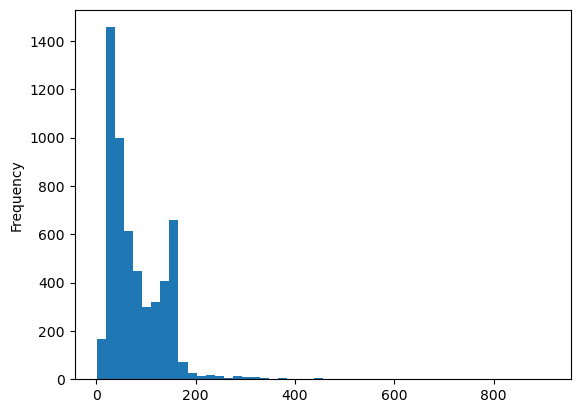

In [7]:
messages['length'].plot(bins=50,kind='hist')

In [8]:
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [9]:
#Determining the longest message in this data set
messages[messages['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

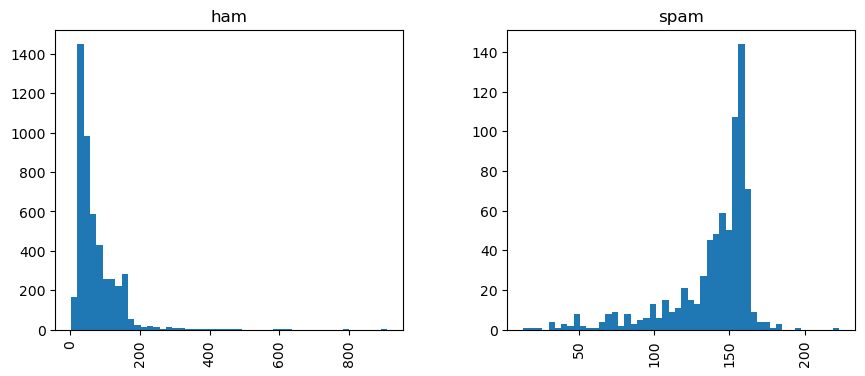

In [10]:
messages.hist(column='length',by='labels',bins=50,figsize=(10,4))

In [11]:
#Initiation of Text analyze
import string

In [12]:
#Removing punctuations
#Example
mess='Sample message! Notice it has punctuation.'

In [13]:
nopunc=[char for char in mess if char not in string.punctuation]

In [14]:
nopunc=''.join(nopunc)

In [15]:
nopunc

'Sample message Notice it has punctuation'

In [18]:
#Creating function to run the loaded text
def text_process(mess):
    nopunc=[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return nopunc

In [19]:
#Removing punctuations from texts
messages['message'].head(5).apply(text_process)

0    Go until jurong point crazy Available only in ...
1                              Ok lar Joking wif u oni
2    Free entry in 2 a wkly comp to win FA Cup fina...
3          U dun say so early hor U c already then say
4    Nah I dont think he goes to usf he lives aroun...
Name: message, dtype: object

In [20]:
messages['labels_cat']=np.where(messages['labels']=='ham',1,0)

In [21]:
#Splitting data into train/test
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test=train_test_split(messages['message'],messages['labels_cat'],test_size=0.2,random_state=123)
label_test=pd.Series(label_test).reset_index(drop=True)

In [22]:
#Text size for train and test sets
print(len(msg_train),len(msg_test))

4457 1115


In [23]:
%%time
#Applying model conditions (word limit=5000, length of sentence=110)
max_words=1000
max_len=80
token=Tokenizer(num_words=max_words)
token.fit_on_texts(msg_train)
vocab_size=len(token.word_index)+1

Wall time: 144 ms


In [24]:
#Transforming raw text into vector format for the training and test data sets
msg_train=token.texts_to_sequences(msg_train)
msg_test=token.texts_to_sequences(msg_test)

In [25]:
#Creating a maximum length of by padding each sequence
msg_train=pad_sequences(msg_train,maxlen=max_len,padding='post',truncating='post')
msg_test=pad_sequences(msg_test,maxlen=max_len,padding='post',truncating='post')
call=tf.keras.callbacks.EarlyStopping(patience=4,min_delta=0.001,restore_best_weights=True)

In [26]:
%%time
#Initializer for the RNN. This function will create the Neural Network.
#Using the Relu funtion (activation function) for two hidden layers and the Sigmoid function for the output layer
u=100
e=12
bz=120

input_lay=layers.Input(shape=(None,),dtype='int64')
x=Embedding(max_words+1,32,input_length=max_len)(input_lay)
x=(layers.Bidirectional(layers.LSTM(u,dropout=0.2,recurrent_dropout=0.2)))(x)
x=(Dense(units=u,activation='relu'))(x)
x=(Dropout(rate=0.2,seed=1234))(x)
x=(Dense(units=u,activation='relu'))(x)
x=(Dropout(rate=0.2,seed=1234))(x)
x=(Dense(units=1,activation='sigmoid'))(x)
spam_detect_model=models.Model(inputs=input_lay,outputs=x)
spam_detect_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
spam_detect_model.fit(msg_train,label_train,batch_size=bz,epochs=e,validation_data=(msg_test,label_test),callbacks=[call])

Epoch 1/12
38/38 [==============================] - 29s 594ms/step - loss: 0.4170 - accuracy: 0.8503 - val_loss: 0.2187 - val_accuracy: 0.9605
Epoch 2/12
38/38 [==============================] - 22s 568ms/step - loss: 0.1114 - accuracy: 0.9690 - val_loss: 0.0777 - val_accuracy: 0.9767
Epoch 3/12
38/38 [==============================] - 22s 580ms/step - loss: 0.0493 - accuracy: 0.9872 - val_loss: 0.0572 - val_accuracy: 0.9839
Epoch 4/12
38/38 [==============================] - 22s 590ms/step - loss: 0.0327 - accuracy: 0.9919 - val_loss: 0.0556 - val_accuracy: 0.9848
Epoch 5/12
38/38 [==============================] - 22s 590ms/step - loss: 0.0224 - accuracy: 0.9951 - val_loss: 0.0618 - val_accuracy: 0.9857
Epoch 6/12
38/38 [==============================] - 22s 588ms/step - loss: 0.0239 - accuracy: 0.9953 - val_loss: 0.0661 - val_accuracy: 0.9821
Epoch 7/12
38/38 [==============================] - 23s 598ms/step - loss: 0.0165 - accuracy: 0.9953 - val_loss: 0.0746 - val_accuracy: 0.9803

In [27]:
#Best model performance was epoch 4, as this epoch obtain the lowest validation loss (0.0556).
spam_detect_model.evaluate(msg_test,label_test)

35/35 [==============================] - 1s 37ms/step - loss: 0.0556 - accuracy: 0.9848


[0.05555106699466705, 0.9847533702850342]

In [28]:
res=spam_detect_model.predict(msg_test)
predictions=np.where(res>=0.5,1,0)

35/35 [==============================] - 2s 35ms/step


In [29]:
#Single predictor correctly determined that "ham" wrote the message
print('Predicted: ',np.where(predictions[1]==1,'ham','spam'))
print('Expected: ',np.where(label_test[1]==1,'ham','spam'))

Predicted:  ['ham']
Expected:  ham


In [30]:
from sklearn.metrics import classification_report

In [31]:
#Model results per test data. The model predicted the test set to a 98% accuracy 
#and a higher f1-score than CatBoost and NB model.
print (classification_report(predictions,label_test,target_names=['spam','ham']))

              precision    recall  f1-score   support

        spam       0.93      0.96      0.94       148
         ham       0.99      0.99      0.99       967

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.97      1115
weighted avg       0.99      0.98      0.98      1115

